Instalações de pacotes e importações

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyswarm import pso
import pandas as pd
from haversine import haversine, Unit

Solução 1 (Medindo pontos pela função de euclides em um mapa 3D)

Média das distâncias iniciais: 0.703402972080454
Stopping search: Swarm best objective change less than 1e-08
Média das distâncias otimizadas: 0.1942803922102813


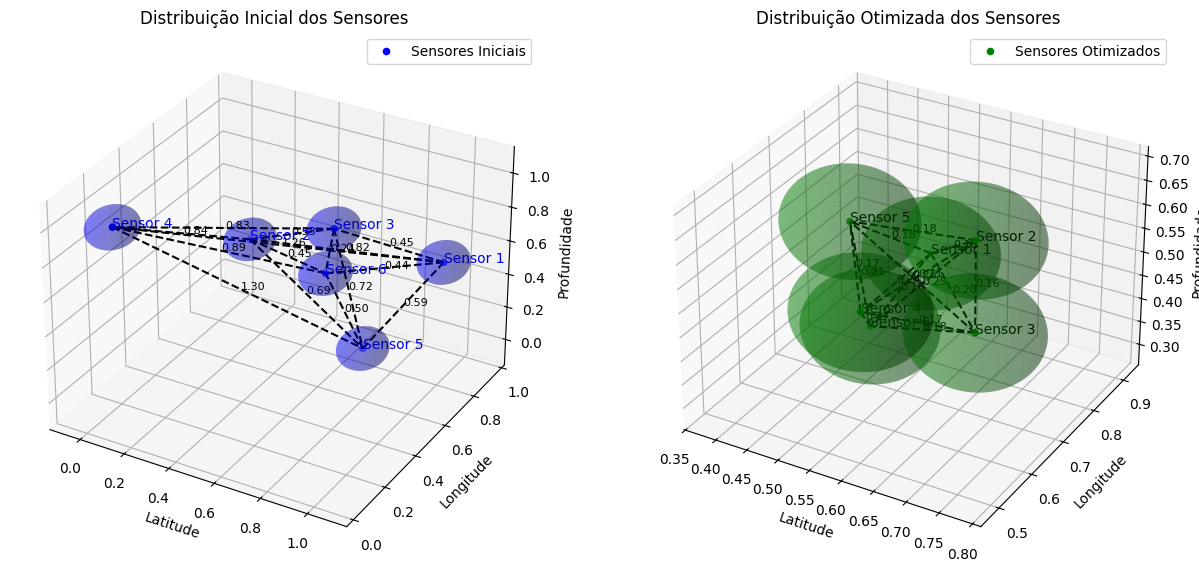

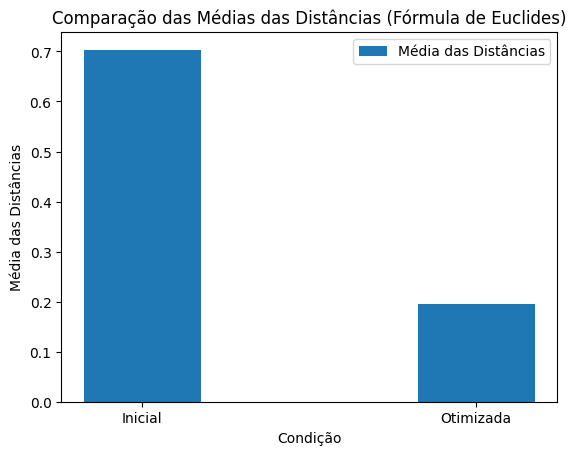

In [3]:
# Solução 1

# Função para calcular a distância euclidiana entre todos os pares de sensores
def calcular_distancias(sensores):
    num_sensores = len(sensores)
    distancias = []
    for i in range(num_sensores):
        for j in range(i + 1, num_sensores):
            dist = np.sqrt(np.sum((sensores[i] - sensores[j])**2))
            distancias.append(dist)
    return distancias

# Gerar Latitude, longitude e profundidade de cada sensor
num_sensores = 6
sensores = np.random.rand(num_sensores, 3)

# Calcular distâncias antes da otimização
distancias_iniciais = calcular_distancias(sensores)
media_distancia_inicial = np.mean(distancias_iniciais)
print("Média das distâncias iniciais:", media_distancia_inicial)

# Plotar os pontos iniciais e os raios de cobertura
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(sensores[:,0], sensores[:,1], sensores[:,2], color='b', label='Sensores Iniciais')

# Função para plotar esferas ao redor dos pontos
def plot_spheres(ax, positions, radius, color):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    for pos in positions:
        x = radius * np.outer(np.cos(u), np.sin(v)) + pos[0]
        y = radius * np.outer(np.sin(u), np.sin(v)) + pos[1]
        z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + pos[2]
        ax.plot_surface(x, y, z, color=color, alpha=0.3)

# Desenhar linhas conectando os pontos para visualizar as distâncias
for i in range(len(sensores)):
    for j in range(i + 1, len(sensores)):
        ax.plot([sensores[i,0], sensores[j,0]],
                [sensores[i,1], sensores[j,1]],
                [sensores[i,2], sensores[j,2]],
                'k--')
        dist = np.sqrt(np.sum((sensores[i] - sensores[j])**2))
        ax.text((sensores[i,0] + sensores[j,0]) / 2,
                (sensores[i,1] + sensores[j,1]) / 2,
                (sensores[i,2] + sensores[j,2]) / 2,
                f'{dist:.2f}', fontsize=8)

# Adicionar nomes aos sensores
for i in range(num_sensores):
    ax.text(sensores[i, 0], sensores[i, 1], sensores[i, 2], f'Sensor {i+1}', color='blue')

plot_spheres(ax, sensores, 0.1, 'b')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Profundidade')
ax.set_title('Distribuição Inicial dos Sensores')
ax.legend()

# Função objetivo para minimizar a distância média entre os sensores
def objective_function(positions):
    num_sensores = len(positions) // 3
    positions = positions.reshape((num_sensores, 3))
    ideal_distance = 0.2  # Defina a distância ideal entre os sensores
    distances = []
    penalties = []
    for i in range(num_sensores):
        for j in range(i + 1, num_sensores):
            dist = np.sqrt(np.sum((positions[i] - positions[j])**2))
            distances.append(dist)
            penalty = (dist - ideal_distance)**2
            penalties.append(penalty)
    return np.mean(penalties)

# Definindo limites para as coordenadas dos sensores (latitude, longitude, profundidade)
lower_bounds = [0, 0, 0] * num_sensores  # Mínimos valores para as coordenadas
upper_bounds = [1, 1, 1] * num_sensores  # Máximos valores para as coordenadas

# Executando a otimização por enxame de partículas
xopt, fopt = pso(objective_function, lower_bounds, upper_bounds, swarmsize=100, maxiter=200)

# Extraindo as posições ótimas dos sensores
optimal_positions = xopt.reshape((num_sensores, 3))

# Calcular distâncias após a otimização
distancias_otimizadas = calcular_distancias(optimal_positions)
media_distancia_otimizada = np.mean(distancias_otimizadas)
print("Média das distâncias otimizadas:", media_distancia_otimizada)

# Plotar os pontos otimizados e os raios de cobertura
ax = fig.add_subplot(122, projection='3d')
ax.scatter(optimal_positions[:, 0], optimal_positions[:, 1], optimal_positions[:, 2], color='g', label='Sensores Otimizados')

# Desenhar linhas conectando os pontos para visualizar as distâncias
for i in range(len(optimal_positions)):
    for j in range(i + 1, len(optimal_positions)):
        ax.plot([optimal_positions[i,0], optimal_positions[j,0]],
                [optimal_positions[i,1], optimal_positions[j,1]],
                [optimal_positions[i,2], optimal_positions[j,2]],
                'k--')
        dist = np.sqrt(np.sum((optimal_positions[i] - optimal_positions[j])**2))
        ax.text((optimal_positions[i,0] + optimal_positions[j,0]) / 2,
                (optimal_positions[i,1] + optimal_positions[j,1]) / 2,
                (optimal_positions[i,2] + optimal_positions[j,2]) / 2,
                f'{dist:.2f}', fontsize=8)

# Adicionar nomes aos sensores
for i in range(num_sensores):
    ax.text(optimal_positions[i, 0], optimal_positions[i, 1], optimal_positions[i, 2], f'Sensor {i+1}', color='black')

plot_spheres(ax, optimal_positions, 0.1, 'g')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Profundidade')
ax.set_title('Distribuição Otimizada dos Sensores')
ax.legend()

plt.show()

# Comparar as médias das distâncias
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(2)
bar1 = plt.bar(index, [media_distancia_inicial, media_distancia_otimizada], bar_width, label='Média das Distâncias')
plt.xlabel('Condição')
plt.ylabel('Média das Distâncias')
plt.title('Comparação das Médias das Distâncias (Fórmula de Euclides)')
plt.xticks(index, ['Inicial', 'Otimizada'])
plt.legend()

plt.show()




Solução 2 (Medindo distâncias de pontos atráves da função de harvesine)

Matriz de Distâncias dos Sensores Inicial (Haversine):
Stopping search: Swarm best objective change less than 1e-08


sensor,A,B,C,D
sensor,,,,
A,0.000000,6749.132343,14358.579093,10797.205081
B,6749.132343,0.000000,14526.307323,13914.287794
C,14358.579093,14526.307323,0.000000,11444.373796
D,10797.205081,13914.287794,11444.373796,0.000000


Matriz de Distâncias dos Sensores Ajustada (Haversine):


sensor,A,B,C,D
sensor,,,,
A,0.000000,241.423292,170.706967,170.706833
B,241.423292,0.000000,170.706565,170.706838
C,170.706967,170.706565,0.000000,241.422899
D,170.706833,170.706838,241.422899,0.000000


Distância Total Inicial: 71789.89 km
Distância Total Ajustada: 1165.67 km
Média da Distância Inicial: 11964.98 km
Média da Distância Ajustada: 194.28 km


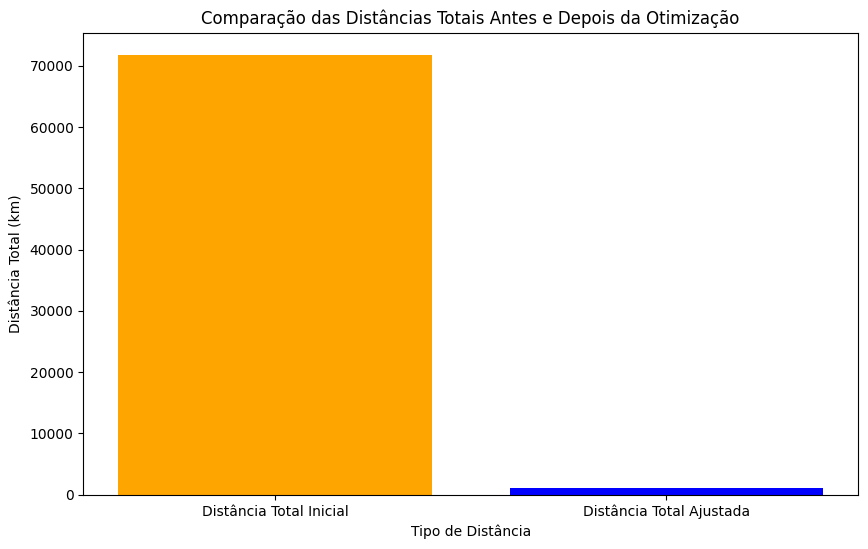

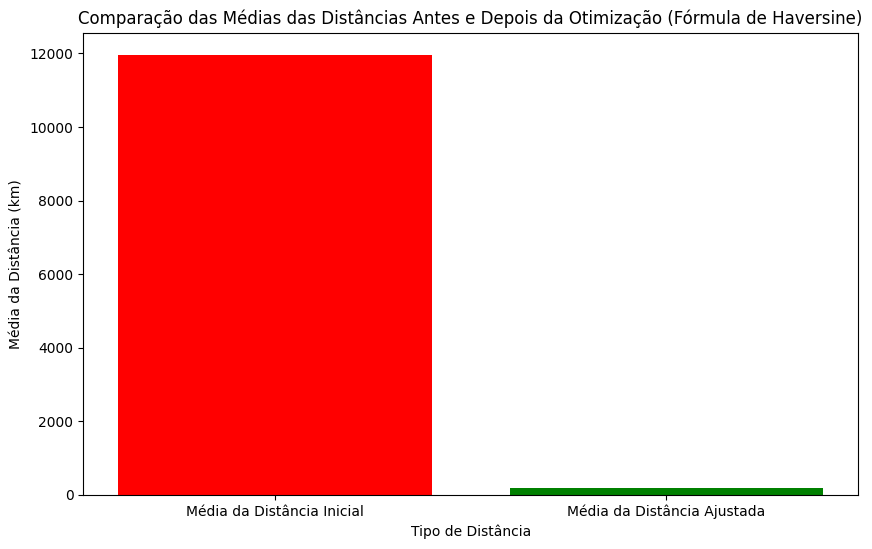

In [4]:
# Solução 2

# Dados de exemplo dos sensores
dados_sensores = {
    'sensor': ['A', 'B', 'C', 'D'],
    'latitude': np.random.rand(4) * 180 - 90,
    'longitude': np.random.rand(4) * 360 - 180
}

# Criando um DataFrame
sensores_df = pd.DataFrame(dados_sensores)

# Calculando a matriz de distâncias usando a biblioteca Haversine
def calcular_matriz_distancias(sensores_df):
    matriz_distancias = []
    for i in range(len(sensores_df)):
        distancias = []
        for j in range(len(sensores_df)):
            if i != j:
                distancia = haversine((sensores_df.at[i, 'latitude'], sensores_df.at[i, 'longitude']),
                                      (sensores_df.at[j, 'latitude'], sensores_df.at[j, 'longitude']), unit=Unit.KILOMETERS)
            else:
                distancia = 0
            distancias.append(distancia)
        matriz_distancias.append(distancias)
    return pd.DataFrame(matriz_distancias, index=sensores_df['sensor'], columns=sensores_df['sensor'])

# Calculando a matriz de distâncias inicial
matriz_distancias_df = calcular_matriz_distancias(sensores_df)

# Exibindo o DataFrame
print("Matriz de Distâncias dos Sensores Inicial (Haversine):")


# Definindo o raio de cobertura dos sensores em quilômetros
sensor_radius = 50

# Função objetivo para minimizar a distância média entre os sensores
def objective_function_haversine(positions):
    num_sensores = len(positions) // 2
    positions = positions.reshape((num_sensores, 2))
    ideal_distance = 200  # Defina a distância ideal entre os sensores em km
    distances = []
    penalties = []
    for i in range(num_sensores):
        for j in range(i + 1, num_sensores):
            dist = haversine((positions[i, 0], positions[i, 1]), (positions[j, 0], positions[j, 1]), unit=Unit.KILOMETERS)
            distances.append(dist)
            if dist < sensor_radius:
                penalty = (dist - ideal_distance)**2 + (sensor_radius - dist)**2
            else:
                penalty = (dist - ideal_distance)**2
            penalties.append(penalty)
    return np.mean(penalties)

# Definindo limites para as coordenadas dos sensores (latitude, longitude)
lower_bounds_haversine = [-90, -180] * len(sensores_df)  # Mínimos valores para as coordenadas
upper_bounds_haversine = [90, 180] * len(sensores_df)    # Máximos valores para as coordenadas

# Executando a otimização por enxame de partículas
xopt_haversine, fopt_haversine = pso(objective_function_haversine, lower_bounds_haversine, upper_bounds_haversine, swarmsize=100, maxiter=200)

# Extraindo as posições ótimas dos sensores
optimal_positions_haversine = xopt_haversine.reshape((len(sensores_df), 2))

# Atualizando as posições otimizadas no DataFrame
sensores_df['latitude'] = optimal_positions_haversine[:, 0]
sensores_df['longitude'] = optimal_positions_haversine[:, 1]

# Calcular a matriz de distâncias ajustada
matriz_distancias_ajustada_df = calcular_matriz_distancias(sensores_df)

# Encontrar os valores mínimo e máximo das matrizes de distância combinadas
min_val = min(matriz_distancias_df.values.min(), matriz_distancias_ajustada_df.values.min())
max_val = max(matriz_distancias_df.values.max(), matriz_distancias_ajustada_df.values.max())

# Plotando a matriz de distâncias inicial como um heatmap
df_estilizado_inicial = matriz_distancias_df.style.background_gradient(cmap='RdYlGn_r', vmin=min_val, vmax=max_val)
display(df_estilizado_inicial)

# Plotando a matriz de distâncias ajustada como um heatmap

print("Matriz de Distâncias dos Sensores Ajustada (Haversine):")
df_estilizado_ajustado = matriz_distancias_ajustada_df.style.background_gradient(cmap='RdYlGn_r', vmin=min_val, vmax=max_val)
display(df_estilizado_ajustado)

# Função para calcular a distância total na matriz de distâncias
def distancia_total(matriz_distancias_df):
    return matriz_distancias_df.values.sum() / 2  # Divide por 2 para evitar contar duas vezes

# Calculando e exibindo a distância total antes e depois da otimização
distancia_total_inicial = distancia_total(matriz_distancias_df)
distancia_total_ajustada = distancia_total(matriz_distancias_ajustada_df)
print(f"Distância Total Inicial: {distancia_total_inicial:.2f} km")
print(f"Distância Total Ajustada: {distancia_total_ajustada:.2f} km")

def media_distancia(matriz_distancias_df):
    # Exclui as distâncias zero (diagonal principal) e calcula a média
    return matriz_distancias_df.values[matriz_distancias_df.values != 0].mean()

# Calculando e exibindo a média da distância antes e depois da otimização
media_distancia_inicial = media_distancia(matriz_distancias_df)
media_distancia_ajustada = media_distancia(matriz_distancias_ajustada_df)
print(f"Média da Distância Inicial: {media_distancia_inicial:.2f} km")
print(f"Média da Distância Ajustada: {media_distancia_ajustada:.2f} km")

# Função para plotar as distâncias totais para melhor visualização
def plotar_distancias_totais(media_distancia_inicial, media_distancia_ajustada):
    plt.figure(figsize=(10, 6))
    distancias = [media_distancia_inicial, media_distancia_ajustada]
    labels = ['Distância Total Inicial', 'Distância Total Ajustada']
    plt.bar(labels, distancias, color=['orange', 'blue'])
    plt.xlabel('Tipo de Distância')
    plt.ylabel('Distância Total (km)')
    plt.title('Comparação das Distâncias Totais Antes e Depois da Otimização')
    plt.show()

plotar_distancias_totais(distancia_total_inicial, distancia_total_ajustada)

def plotar_medias_distancias(media_inicial, media_ajustada):
    plt.figure(figsize=(10, 6))
    distancias = [media_inicial, media_ajustada]
    labels = ['Média da Distância Inicial', 'Média da Distância Ajustada']
    plt.bar(labels, distancias, color=['red', 'green'])
    plt.xlabel('Tipo de Distância')
    plt.ylabel('Média da Distância (km)')
    plt.title('Comparação das Médias das Distâncias Antes e Depois da Otimização (Fórmula de Haversine)')
    plt.show()

plotar_medias_distancias(media_distancia_inicial, media_distancia_ajustada)
